In [1]:
# Input: 
path_data = '../01 data/train_pollution.csv'
target_var = 'target_carbon_monoxide'
n_lag = 3
split_ratio_train = 0.65
split_ratio_val = 0.15
split_ratio_test = 0.2

In [ ]:
# data source: https://www.kaggle.com/c/tabular-playground-series-jul-2021/data?select=train.csv

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
print(data.shape)
data.head(3)

(7111, 12)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1


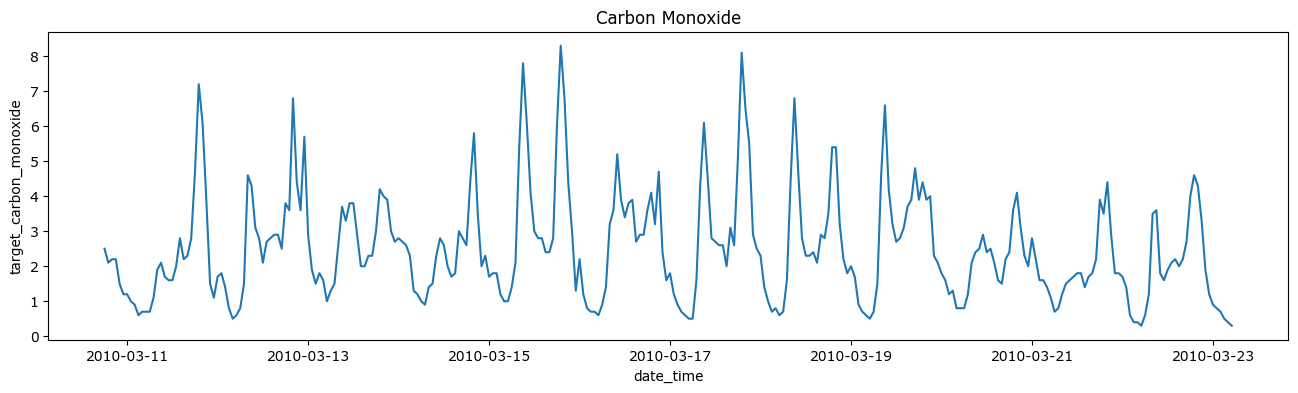

In [40]:
# Visualize CO
plt.figure(figsize=(16,4))
sns.lineplot(data=data.iloc[:300,:], x='date_time', y='target_carbon_monoxide')
plt.title('Carbon Monoxide')
plt.show()

In [60]:
# Correlation
data.corr()['target_carbon_monoxide']

C:\Users\Danamas\AppData\Local\Temp\ipykernel_11732\3617933086.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['target_carbon_monoxide']


deg_C                    -0.007503
relative_humidity         0.016589
absolute_humidity        -0.013756
sensor_1                  0.857215
sensor_2                  0.821025
sensor_3                 -0.547567
sensor_4                  0.571412
sensor_5                  0.834501
target_carbon_monoxide    1.000000
target_benzene            0.881884
target_nitrogen_oxides    0.806099
Name: target_carbon_monoxide, dtype: float64

In [4]:
# Select features
# If univariate, select the only target var.
# If multivariate, select the target var and features.
data = data[
    ['target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]

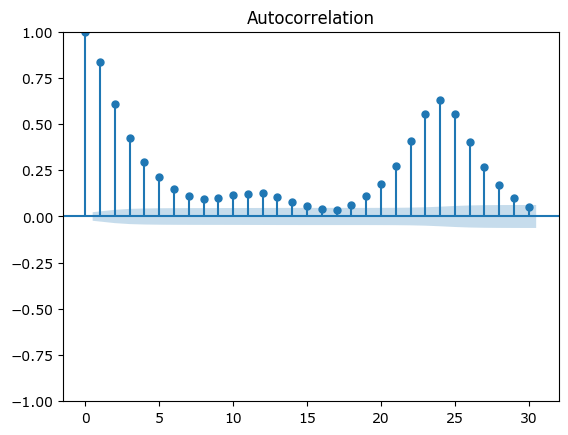

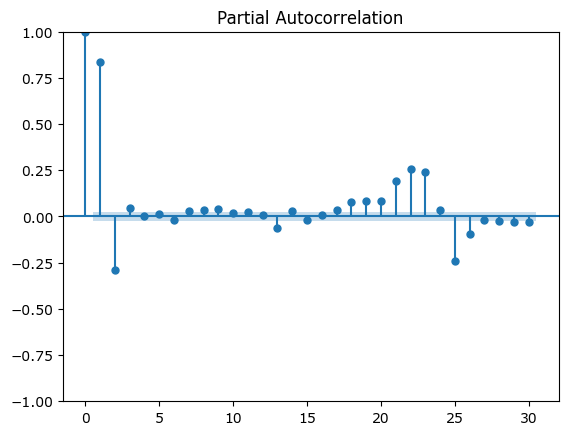

In [8]:
# Autocorrelation
plot_acf(data['target_carbon_monoxide'], lags=30)
plot_pacf(data['target_carbon_monoxide'], lags=30)
# pacf shows that the dependence can be captured using lags 1 until 3
plt.show()

In [5]:
# Feature engineering with lag time
def feature_shift_time(data: pd.DataFrame, lag=1, n_out=1, dropnan=True):
    var_names = list(data.columns)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    column, feature = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        column.append(df.shift(i))
        feature += [f'{v}(t-{i})' for v in var_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        column.append(df.shift(-i))
        if i == 0:
            feature += [f'{v}(t)' for v in var_names]
        else:
            feature += [f'{v}(t+{i})' for v in var_names]
    # put it all together
    agg = pd.concat(column, axis=1)
    agg.columns = feature
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# Train, val, test split
end_train = int(round(split_ratio_train * len(data), 0))
end_val = int(round((split_ratio_val + split_ratio_train) * len(data), 0))

In [ ]:
# Standard scaler
scaler = StandardScaler()
scaler.fit(data.iloc[:end_train, :])
# Save the scaler
# pickle.dump(scaler, open('../03 outputs/01/time_scaler.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load standard scaler
scaler = pickle.load(open('../03 outputs/01/time_scaler.pickle', 'rb'))

In [12]:
# Scale
data_prep = data.copy()
data_prep = pd.DataFrame(scaler.transform(data), columns=data_prep.columns)

# Feature engineering with lag time
data_prep = feature_shift_time(data_prep, lag=n_lag)

# Remove features at time t
drop_col = [c for c in data_prep.columns if '(t)' in c and c != target_var]
data_prep = data_prep.drop(columns=[])

print(data_prep.shape)
data_prep.head(3)

(7108, 24)


,target_carbon_monoxide(t-3),sensor_1(t-3),sensor_2(t-3),sensor_5(t-3),target_benzene(t-3),target_nitrogen_oxides(t-3),target_carbon_monoxide(t-2),sensor_1(t-2),sensor_2(t-2),sensor_5(t-2),...,sensor_2(t-1),sensor_5(t-1),target_benzene(t-1),target_nitrogen_oxides(t-1),target_carbon_monoxide(t),sensor_1(t),sensor_2(t),sensor_5(t),target_benzene(t),target_nitrogen_oxides(t)
3,0.548406,1.579574,0.661965,1.054539,0.371265,0.470854,0.212758,1.035971,-0.113891,0.223051,...,0.047033,0.535337,-0.047421,0.017357,0.296670,1.246674,0.044701,0.965651,0.027344,0.576968
4,0.212758,1.035971,-0.113891,0.223051,0.057250,-0.297634,0.296670,1.301487,0.047033,0.535337,...,0.044701,0.965651,0.027344,0.576968,-0.290715,1.000267,-0.251881,0.580076,-0.466107,-0.041843
5,0.296670,1.301487,0.047033,0.535337,-0.047421,0.017357,0.296670,1.246674,0.044701,0.965651,...,-0.251881,0.580076,-0.466107,-0.041843,-0.542452,0.743301,-0.855152,0.040859,-0.765169,-0.418268


In [13]:
# Create X and y
X_col = [c for c in data_prep if '(t)' not in c]
y_col = [f'{target_var}(t)'] # [c for c in data_prep if '(t)' in c]

X_train = data_prep.loc[:end_train, X_col]
X_val = data_prep.loc[end_train:end_val, X_col]
X_test = data_prep.loc[end_val:, X_col]

y_train = data_prep.loc[:end_train, y_col]
y_val = data_prep.loc[end_train:end_val, y_col]
y_test = data_prep.loc[end_val:, y_col]

In [20]:
# Save
X_train.to_csv('../03 outputs/01/X_train.csv')
y_train.to_csv('../03 outputs/01/y_train.csv')
X_val.to_csv('../03 outputs/01/X_val.csv')
y_val.to_csv('../03 outputs/01/y_val.csv')
X_test.to_csv('../03 outputs/01/X_test.csv')
y_test.to_csv('../03 outputs/01/y_test.csv')

In [21]:
# Reshape input to be 3D [samples, timesteps, features]
n_features = len(data.columns)
X_train = X_train.values.reshape((X_train.shape[0], n_lag, n_features))
X_val = X_val.values.reshape((X_val.shape[0], n_lag, n_features))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4620, 3, 6) (4620, 1) (1068, 3, 6) (1068, 1)


In [22]:
# Save
np.save('../03 outputs/01/X_train.npy', X_train)
np.save('../03 outputs/01/X_val.npy', X_val)
np.save('../03 outputs/01/y_train.npy', y_train)
np.save('../03 outputs/01/y_val.npy', y_val)